# Exploratory Data Analysis — Part 3 (Multivariate Analysis)

### Description
This notebook focuses on identifying **interactions and dependencies between multiple features** in the clinical trial dataset.  
While previous EDA stages examined univariate and bivariate relationships, this part explores **how combinations of variables jointly influence trial outcomes**.

### Key steps
1. **Categorical × Categorical Analysis**
   - Performed **Chi-square tests** for all unique categorical pairs against `overall_status`.  
   - Measured association strength using **Cramér’s V**.  
   - Displayed inline plots only for significant pairs (**Cramér’s V > 0.15**).  

2. **Heatmap Visualization**
   - Created **residual heatmaps** showing deviations between observed vs expected outcomes.  
   - Generated **success-rate heatmaps** to visualize actual success proportions across feature combinations.  

3. **Categorical × Numerical Analysis**
   - Applied **Mann–Whitney U tests** to compare numeric features (e.g., enrollment, duration) across categories.  
   - Reported **median, IQR, and effect size (r)** for each relationship.  
   - Visualized results as **point plots (median ± IQR)** to show trend differences.  

4. **Feature Refinement**
   - Identified **redundant or strongly correlated variables** to improve modeling efficiency.  
   - Exported all significant multivariate relationships for later use in model feature engineering.

### **Expected Outcomes**
- Discover combinations of trial design elements that influence study completion success.  
- Quantify inter-variable dependencies that may explain shared variance in model performance.  
- Prepare a **feature-optimized dataset (`df_EDA_3.csv`)** ready for the modeling phase.

### Outputs
- Tables/plots under: `../results/EDA3_outputs/`
- Final processed dataset → `../data/processed/df_EDA_3.csv`

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from itertools import combinations

# Paths
DATA_PROCESSED = Path("../data/processed")
RESULTS_DIR = Path("../results/EDA3_outputs")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Utility: safe save figure
def savefig(filename, tight=True, dpi=200, show=True):
    if tight:
        plt.tight_layout()
    filepath = RESULTS_DIR / filename
    plt.savefig(filepath, dpi=dpi)
    if show:
        plt.show()
    plt.close()

In [2]:
# Load dataset
df_EDA_3 = pd.read_csv(DATA_PROCESSED / "df_EDA_2.csv",  keep_default_na = False)

print("✅ Loaded dataset")
print("Shape:", df_EDA_3.shape)

✅ Loaded dataset
Shape: (263136, 95)


In [3]:
# === Helper Function 1: Chi-Square Analysis (Cat x Cat vs Target) ===
def multivariate_cat_summary(df, cat_cols, target_col='overall_status'):
    """
    Run chi-square tests for all unique pairs of categorical variables vs target.

    Parameters:
    - df (pd.DataFrame): Input dataset (e.g., df_EDA_2)
    - cat_cols (list[str]): List of categorical columns
    - target_col (str): Target column (default = 'overall_status')

    Returns:
    - summary_df (pd.DataFrame): Table with Chi² results and effect sizes
    """
    results = []

    # Generate all unique combinations of categorical column pairs
    for col1, col2 in combinations(cat_cols, 2):
        contingency = pd.crosstab([df[col1], df[col2]], df[target_col])
        contingency.columns = ['Failure', 'Success']

        # Chi-square test
        chi2, p, dof, expected = chi2_contingency(
            contingency[['Success', 'Failure']], correction=False
        )

        # Cramér's V
        n = contingency[['Success', 'Failure']].sum().sum()
        r, c = contingency[['Success', 'Failure']].shape
        cramers_v = np.sqrt((chi2 / n) / min(r - 1, c - 1))

        results.append({
            'Col1': col1,
            'Col2': col2,
            'Chi2': round(chi2, 2),
            'p_value': f'{p:.2g}',
            "Cramers_v": round(cramers_v, 3)
        })

     # Build results table
    summary_df = pd.DataFrame(results).sort_values('Cramers_v', ascending=False).reset_index(drop=True)
    
    summary_df.to_csv(RESULTS_DIR / 'Multivariate_cat_summary.csv', index=False)
    print("Chi-square summary (Multivariate analysis):")
    display(summary_df)
    return summary_df

# === Helper Function 2: Heatmaps for Categorical Features ===
def multivariate_cat_heatmaps(df, col1, col2, target_col='overall_status', resid_figsize=(16, 8), success_figsize=(12, 8), x_ticks=0, show=False):
    """
    Generate residual heatmaps and success rate heatmap for two categorical features.

    Parameters:
    - df (pd.DataFrame): Input dataset
    - col1, col2 (str): Categorical column names
    - target_col (str): Target column (default = 'overall_status')
    - resid_figsize (tuple): Figure size for residual heatmaps
    - success_figsize (tuple): Figure size for success rate heatmap
    - x_ticks (int): Rotation for x-ticks
    - show (bool): If True, display plots inline
    """
    contingency = pd.crosstab([df[col1], df[col2]], df[target_col])
    contingency.columns = ['Failure', 'Success']

    # Expected values + residuals
    chi2, p, dof, expected = chi2_contingency(contingency[['Success', 'Failure']], correction=False)
    expected_df = pd.DataFrame(expected, index=contingency.index).round(2)
    expected_df.columns = ['Expected_success', 'Expected_failure']
    residual = ((contingency[['Success', 'Failure']] - expected) / np.sqrt(expected)).round(0)
    residual.columns = ['Residual_success', 'Residual_failure']

    # Residual heatmaps
    fig, axes = plt.subplots(1, 2, figsize=resid_figsize)

    sns.heatmap(residual['Residual_success'].unstack(level=1),
                annot=True, fmt=".1f", cmap="coolwarm", center=0,
                cbar_kws={"label": "Std. Residual (Success)"}, ax=axes[0])
    axes[0].set_title(f"{col1} × {col2} — Residuals (Success)", fontsize=12, fontweight='bold')
    axes[0].set_ylabel(col1, fontsize=10, fontweight='bold')
    axes[0].set_xlabel(col2, fontsize=10, fontweight='bold')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=x_ticks)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

    sns.heatmap(residual['Residual_failure'].unstack(level=1),
                annot=True, fmt=".1f", cmap="coolwarm", center=0,
                cbar_kws={"label": "Std. Residual (Failure)"}, ax=axes[1])
    axes[1].set_title(f"{col1} × {col2} — Residuals (Failure)", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("")
    axes[1].set_xlabel(col2, fontsize=10, fontweight='bold')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=x_ticks)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

    plt.tight_layout()
    savefig(f"{col1}_{col2}_residuals.png", show=show)

    # Success rate heatmap
    success_rate = pd.crosstab(df[col1], df[col2], values=(df[target_col] == 1), aggfunc='mean') * 100
    plt.figure(figsize=success_figsize)
    sns.heatmap(success_rate, annot=True, cmap='Greens', cbar_kws={'label': 'Success Rate (%)'})
    plt.title(f"Success rate: {col1} × {col2}", fontsize=14, fontweight='bold')
    plt.ylabel(col1, fontsize=12, fontweight='bold')
    plt.xlabel(col2, fontsize=12, fontweight='bold')
    plt.yticks(rotation=0)

    savefig(f"{col1}_{col2}_success_rate.png", show=show)

# === Helper Function 3: Mann-Whitney U Test (Num x Cat vs Target) ===
def analysis_num_cat_target(df, cat_col, num_col, target_col="overall_status", figsize=(10, 6), rotation=0, show=False):
    """
    Perform Mann-Whitney U tests comparing a numerical feature across categories of a 
    categorical feature with respect to a binary target (e.g., success vs failure).

    Parameters:
    - df (pd.DataFrame): Input dataset
    - cat_col (str): Categorical column (e.g., 'phase_grouped')
    - num_col (str): Numerical column (e.g., 'enrollment')
    - target_col (str): Target column (default = 'overall_status')
    - figsize (tuple): Size of the output figure
    - rotation (int): Rotation angle for x-axis labels
    - show (bool): If True, show the plot inline

    Returns:
    - results_df (pd.DataFrame): Test summary with medians, IQR, U-statistic, p-value, and effect size
    """
    results = []

    # Loop through each category
    for level in df[cat_col].dropna().unique():
        data = df[df[cat_col] == level]
        success = data[data[target_col] == 1][num_col].dropna()
        failure = data[data[target_col] == 0][num_col].dropna()

        if success.empty or failure.empty:
            continue  # skip categories with missing groups

        # Mann-Whitney U test
        U, p = mannwhitneyu(success, failure, alternative="two-sided")

        # Effect size (r)
        n1, n2 = len(success), len(failure)
        N = n1 + n2
        z = (U - (n1 * n2) / 2) / np.sqrt(n1 * n2 * (N + 1) / 12)
        effect_size_r = abs(z) / np.sqrt(N)

        # Store results
        results.append({
            "Category": level,
            "Total_success": n1,
            "Total_failure": n2,
            "Median_success": np.median(success).round(2),
            "IQR_success": (np.percentile(success, 75) - np.percentile(success, 25)).round(2),
            "Median_failure": np.median(failure).round(2),
            "IQR_failure": (np.percentile(failure, 75) - np.percentile(failure, 25)).round(2),
            "U_stat": f"{U:.2e}",
            "p_value": f"{p:.2g}",
            "Effect_size_r": round(effect_size_r, 3),
        })

    # Build summary DataFrame
    results_df = pd.DataFrame(results).sort_values('Median_success', ascending=False).reset_index(drop=True)

    # Save summary CSV
    file_path = RESULTS_DIR / f"{num_col}_by_{cat_col}_mw_summary.csv"
    results_df.to_csv(file_path, index=False)
    display(results_df)

    # Create point plot (median ± IQR)
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(len(results_df))

    # Success (blue points)
    ax.errorbar(
        x - 0.1, results_df['Median_success'],
        yerr=results_df['IQR_success'] / 2,
        fmt='o', color='blue', capsize=5, label='Success (median ± IQR)'
    )

    # Failure (red points)
    ax.errorbar(
        x + 0.1, results_df['Median_failure'],
        yerr=results_df['IQR_failure'] / 2,
        fmt='o', color='red', capsize=5, label='Failure (median ± IQR)'
    )

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Category'], rotation=rotation, ha='right')
    ax.set_ylabel(num_col, fontsize=12, fontweight='bold')
    ax.set_xlabel(cat_col, fontsize=12, fontweight='bold')
    ax.set_title(f"{num_col} by {cat_col} (median ± IQR, Success vs Failure)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.tight_layout()

    # Save figure
    fig_path = f"{num_col}_by_{cat_col}_overall.png"
    savefig(fig_path, show=show)


In [4]:
cat_cols = [
    'phase_grouped', 'intervention_grouped', 'condt_grouped',
    'allocation_grouped', 'masking_grouped', 'model_grouped',
    'purpose_grouped', 'sponsor_grouped', 'elig_age_grouped', 'elig_gender_grouped'
]

summary_df = multivariate_cat_summary(df_EDA_3, cat_cols)

Chi-square summary (Multivariate analysis):


,Col1,Col2,Chi2,p_value,Cramers_v
0,intervention_grouped,condt_grouped,9407.68,0,0.189
1,phase_grouped,condt_grouped,7977.48,0,0.174
2,intervention_grouped,model_grouped,7594.18,0,0.170
3,condt_grouped,model_grouped,7095.81,0,0.164
4,condt_grouped,purpose_grouped,6782.58,0,0.161
5,phase_grouped,intervention_grouped,6452.81,0,0.157
6,phase_grouped,model_grouped,6509.26,0,0.157
7,intervention_grouped,allocation_grouped,6457.81,0,0.157
8,condt_grouped,masking_grouped,6442.54,0,0.156
9,intervention_grouped,purpose_grouped,6272.97,0,0.154


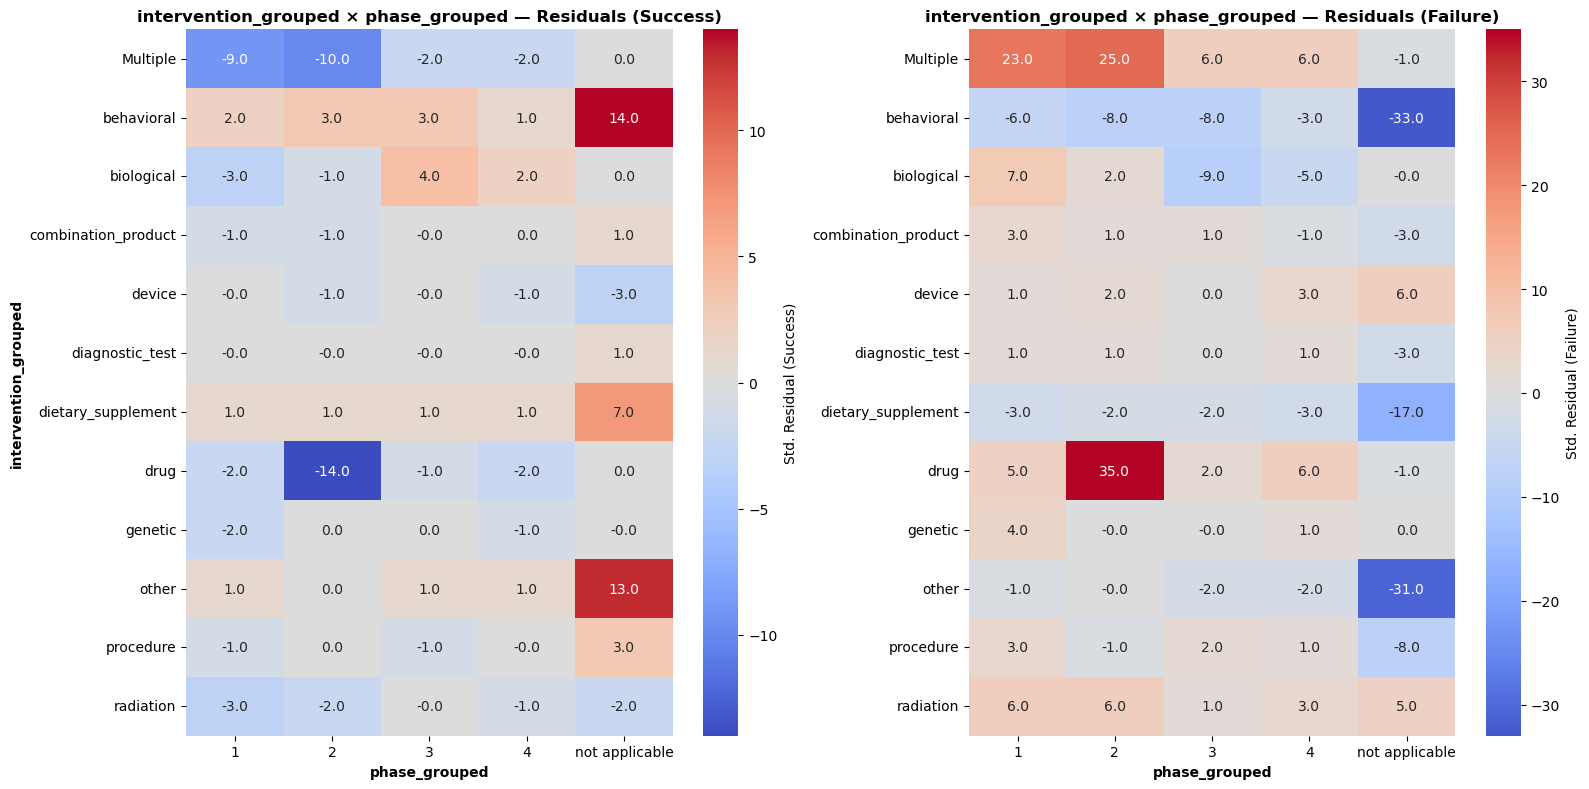

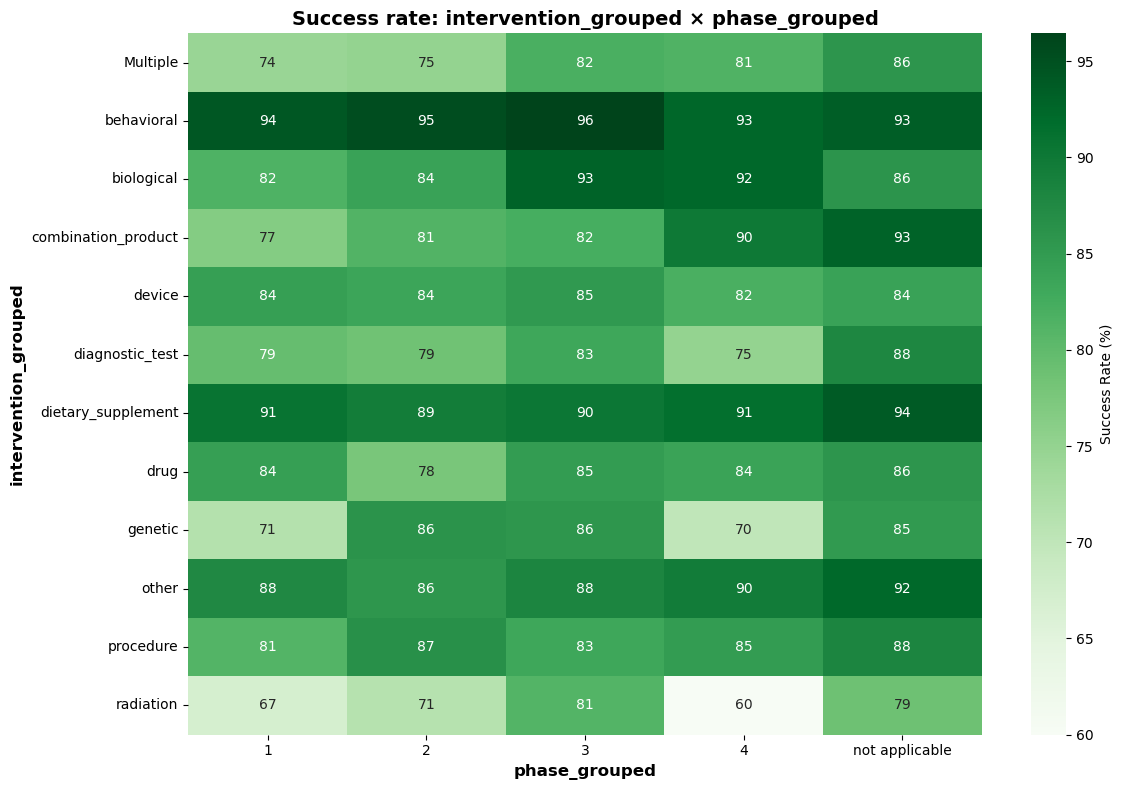

In [5]:
# Heatmaps for a specific pair
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'phase_grouped', show=True)


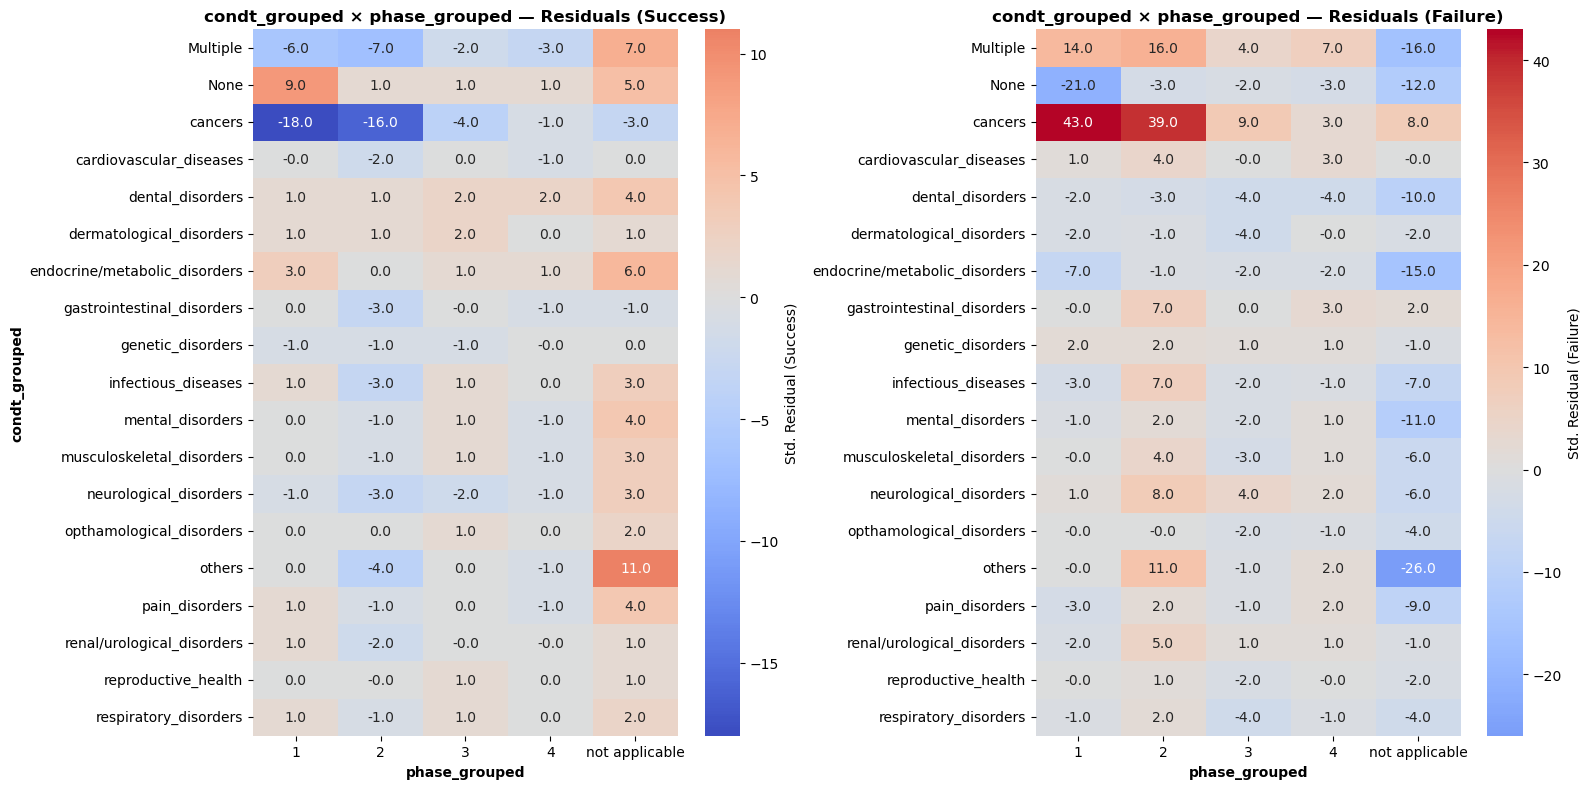

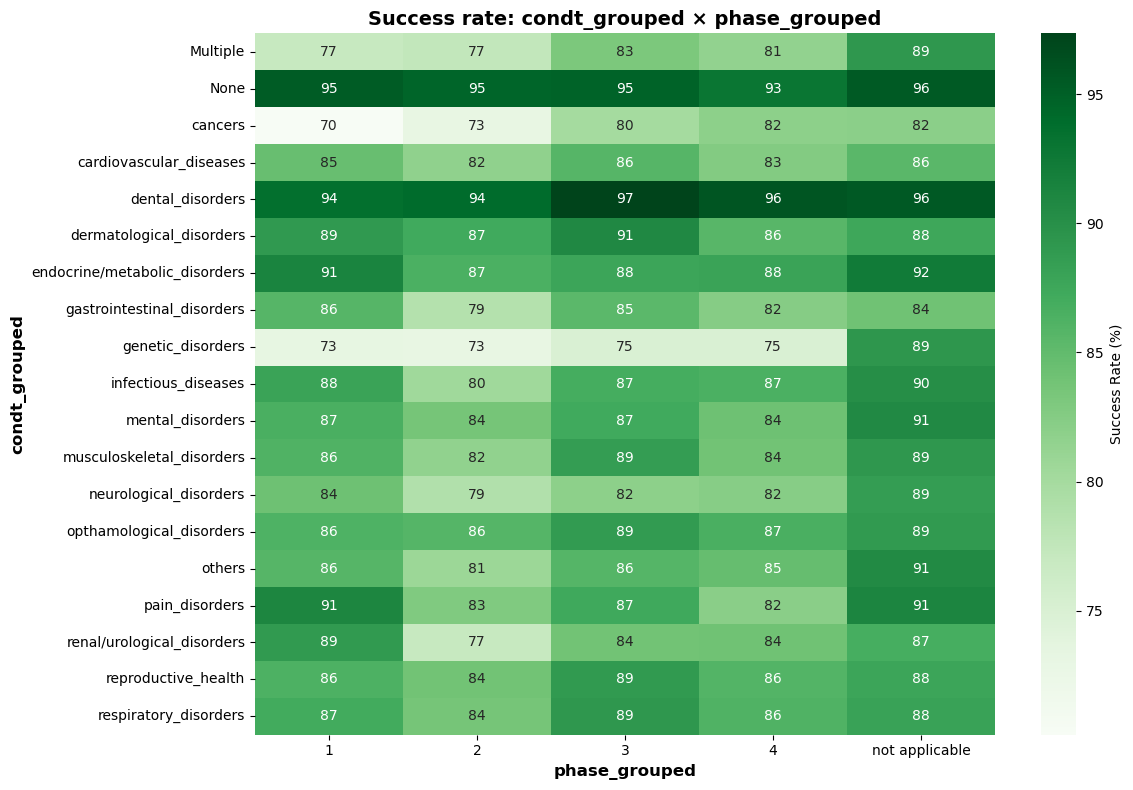

In [6]:
multivariate_cat_heatmaps(df_EDA_3, 'condt_grouped', 'phase_grouped', show=True)


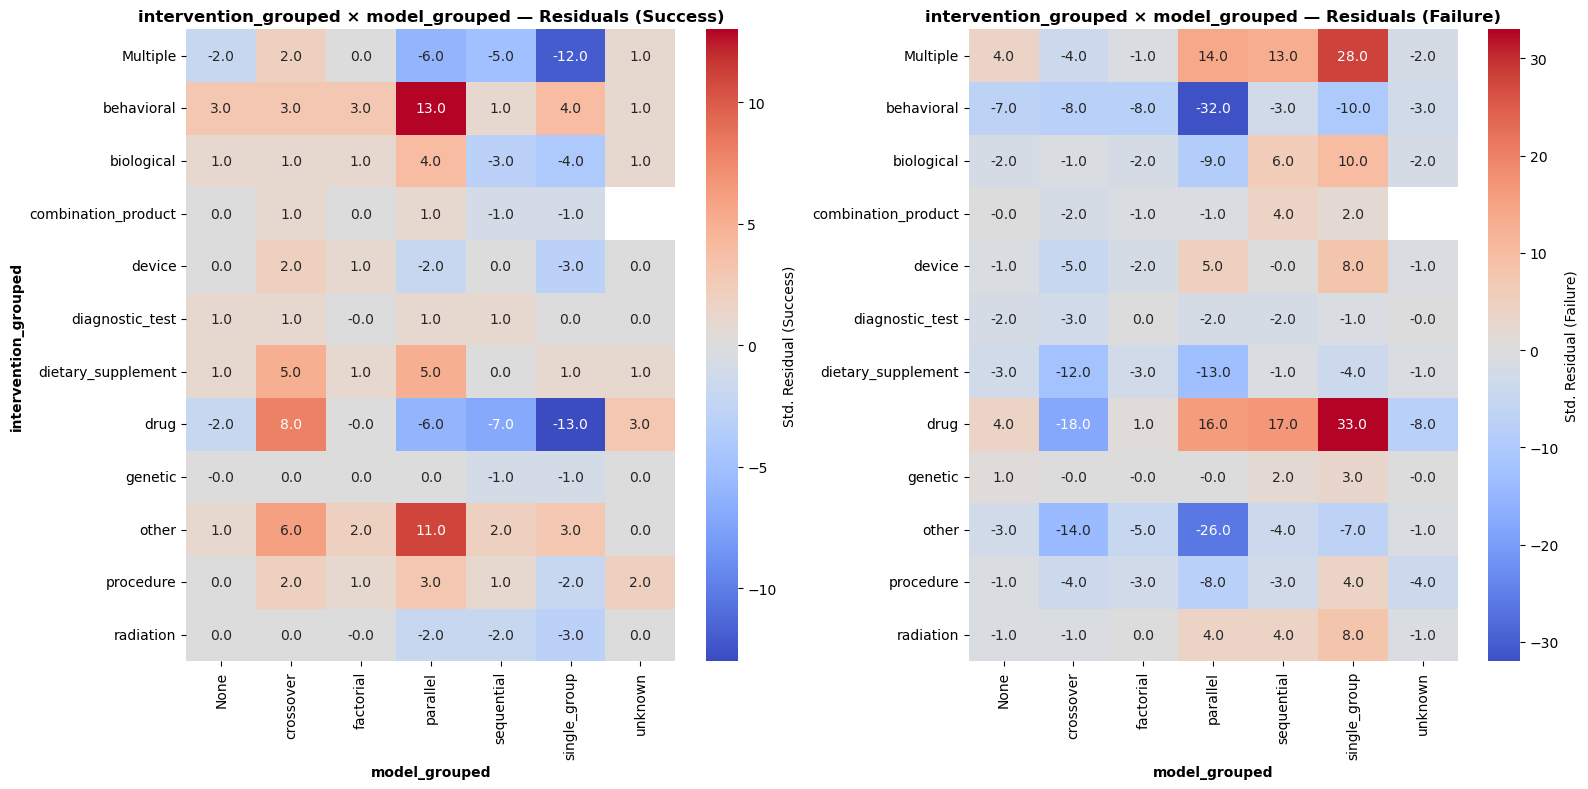

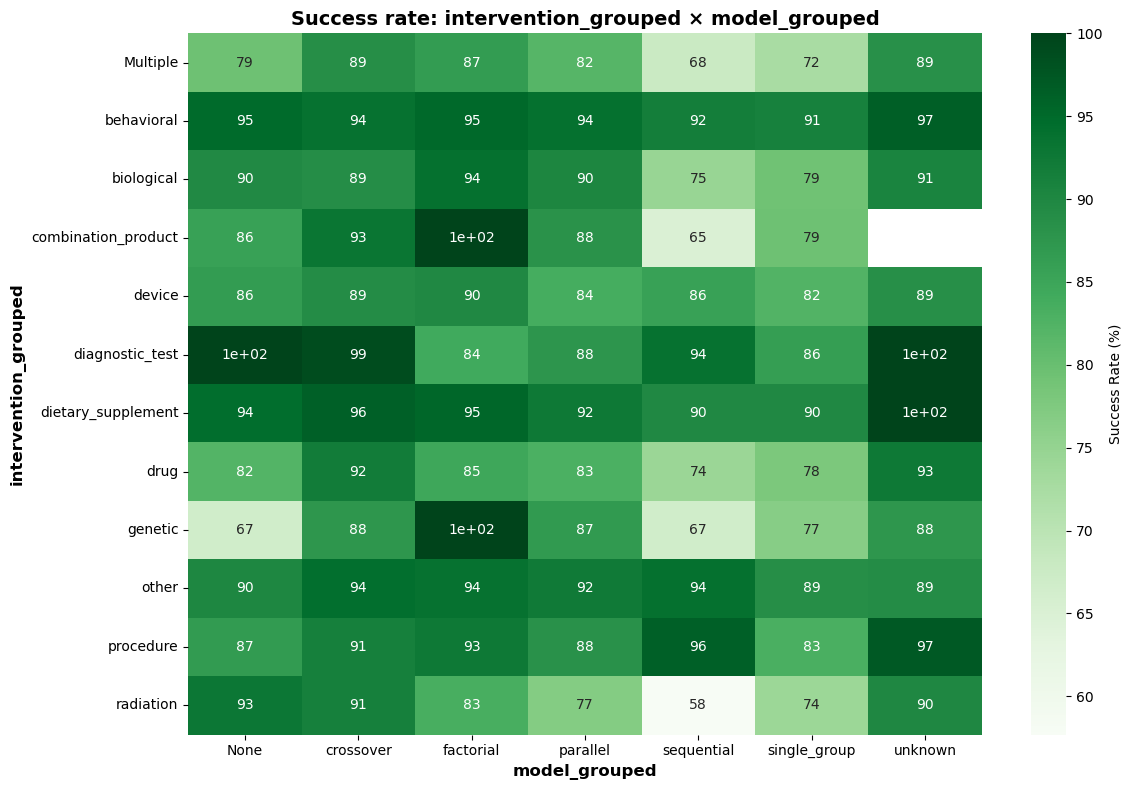

In [7]:
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'model_grouped', x_ticks = 90, show=True)


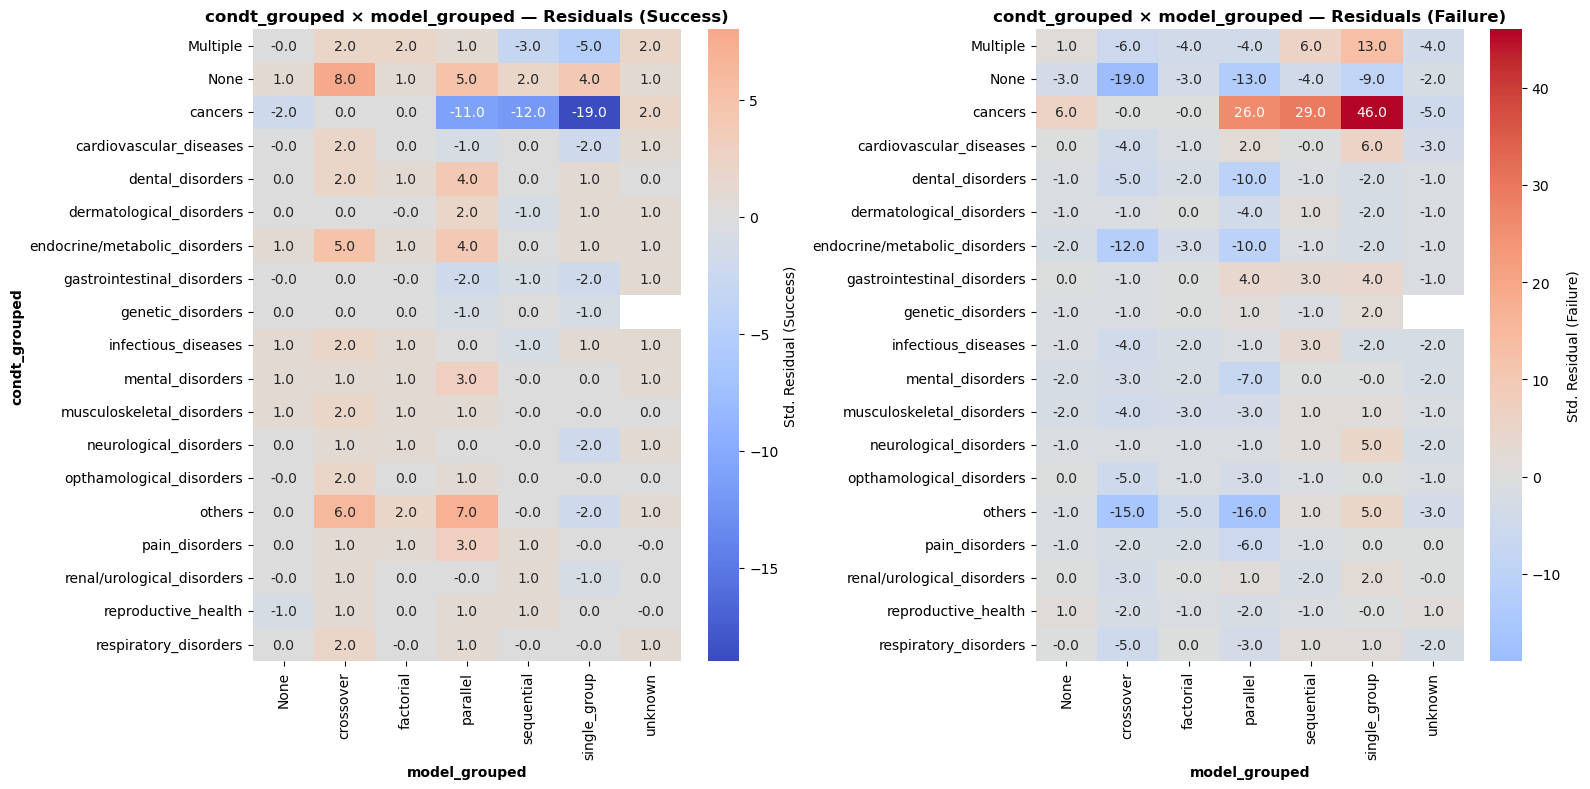

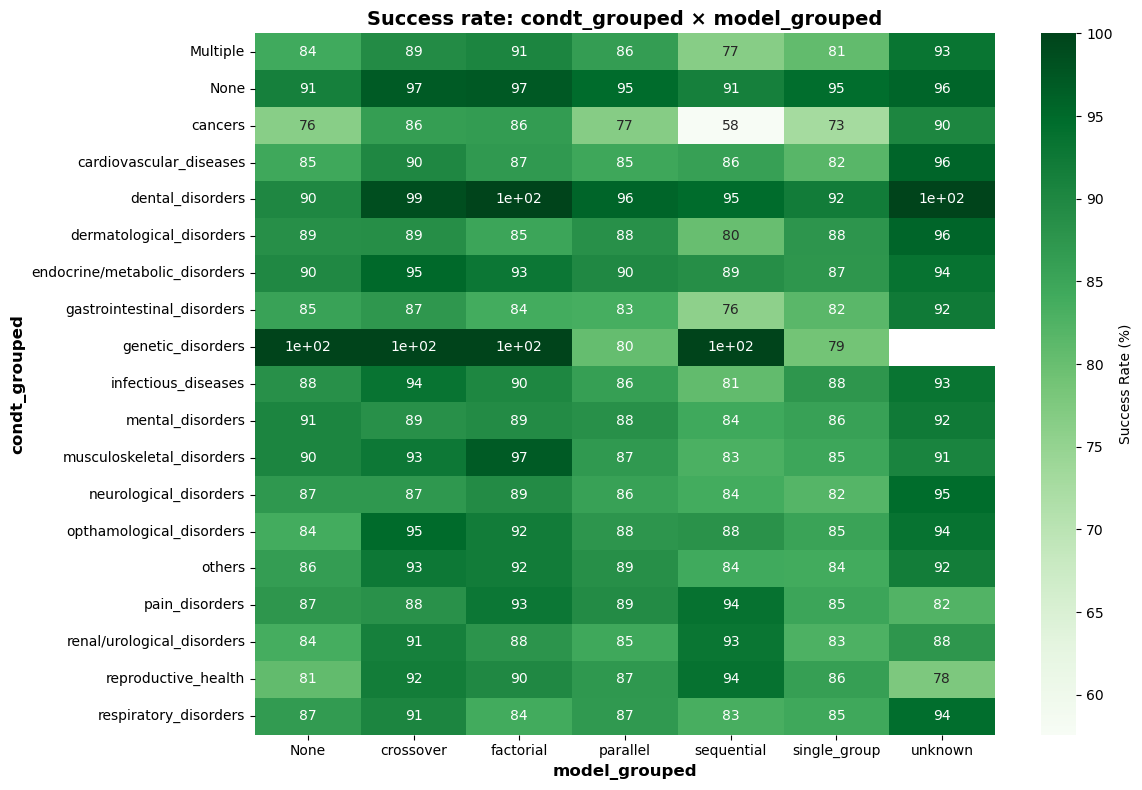

In [8]:
multivariate_cat_heatmaps(df_EDA_3, 'condt_grouped', 'model_grouped',  x_ticks = 90, show=True)


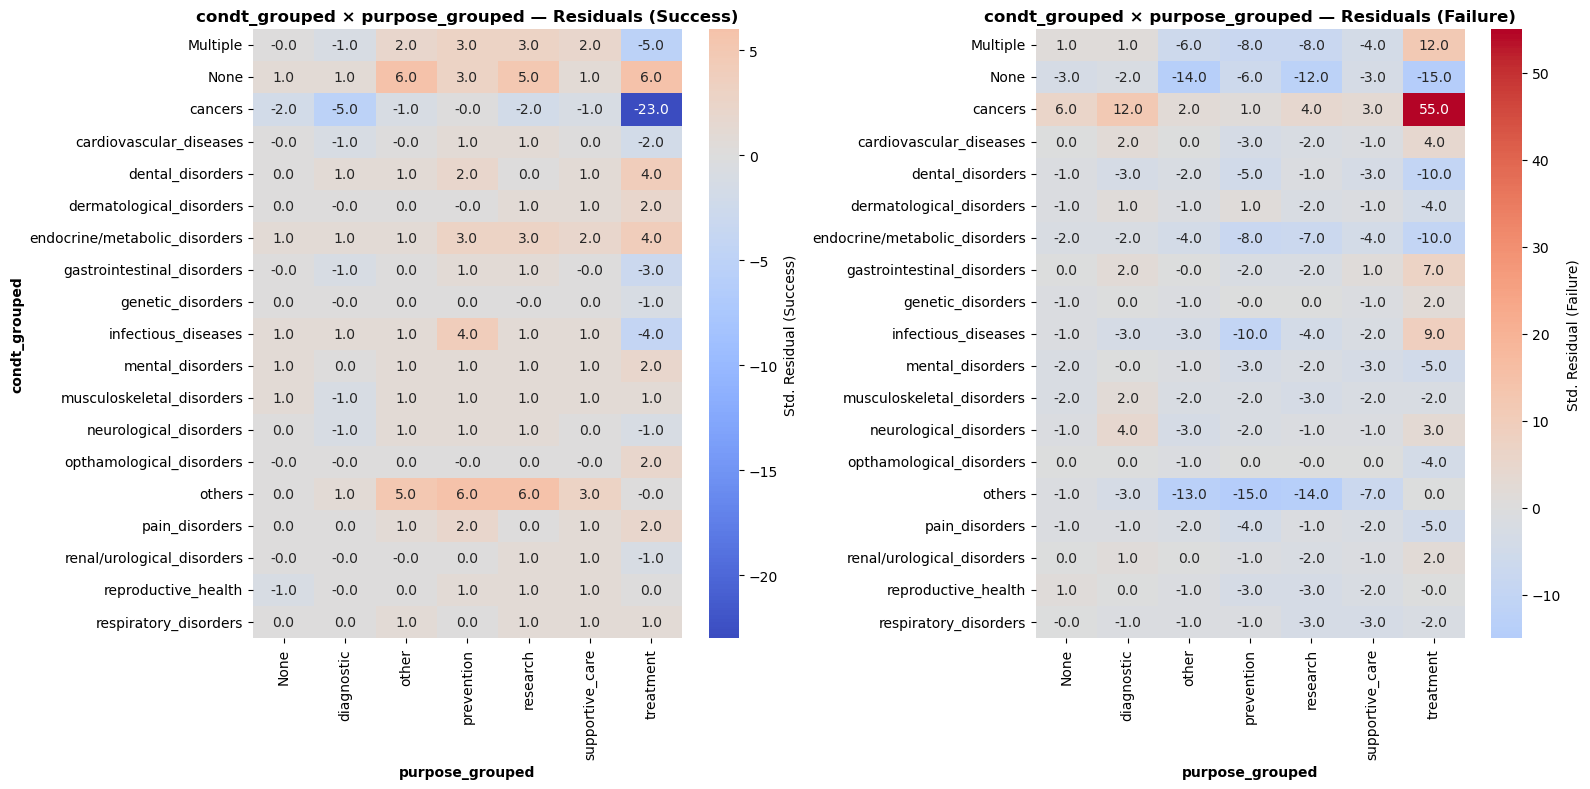

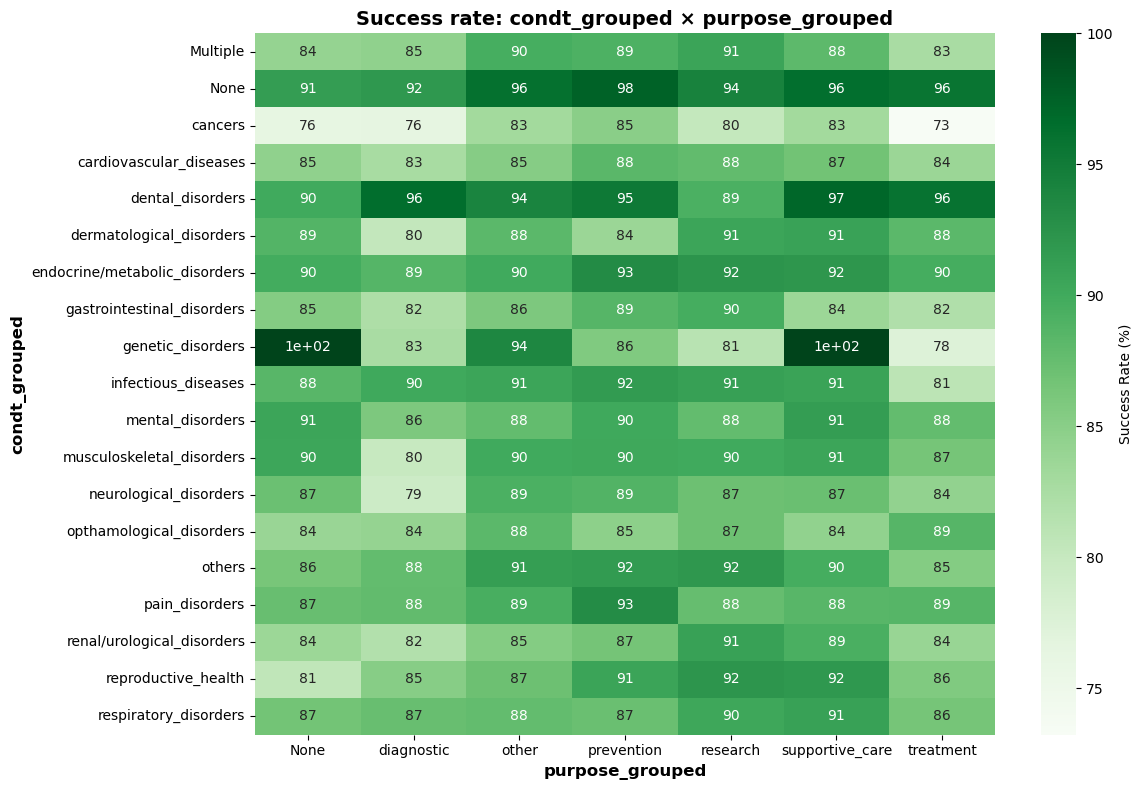

In [9]:
multivariate_cat_heatmaps(df_EDA_3, 'condt_grouped', 'purpose_grouped', x_ticks = 90, show=True)


In [10]:
# Save plots for remaining categorical pairs with Cramér’s V > 0.15
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'phase_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'model_grouped', 'phase_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'allocation_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'condt_grouped', 'masking_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'purpose_grouped', x_ticks = 90, show=False)
multivariate_cat_heatmaps(df_EDA_3, 'condt_grouped', 'allocation_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'masking_grouped', show=False)
multivariate_cat_heatmaps(df_EDA_3, 'intervention_grouped', 'phase_grouped', show=False)


,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,3,24876,4254,248.0,429.0,48.0,233.75,7.83e+07,0,0.293
1,4,19426,3685,80.0,157.0,9.0,40.00,5.94e+07,0,0.418
2,2,35230,9636,60.0,90.0,10.0,37.00,2.75e+08,0,0.441
3,not applicable,110318,13206,60.0,100.0,5.0,29.00,1.21e+09,0,0.356
4,1,35197,7308,30.0,31.0,6.0,20.00,2.08e+08,0,0.405


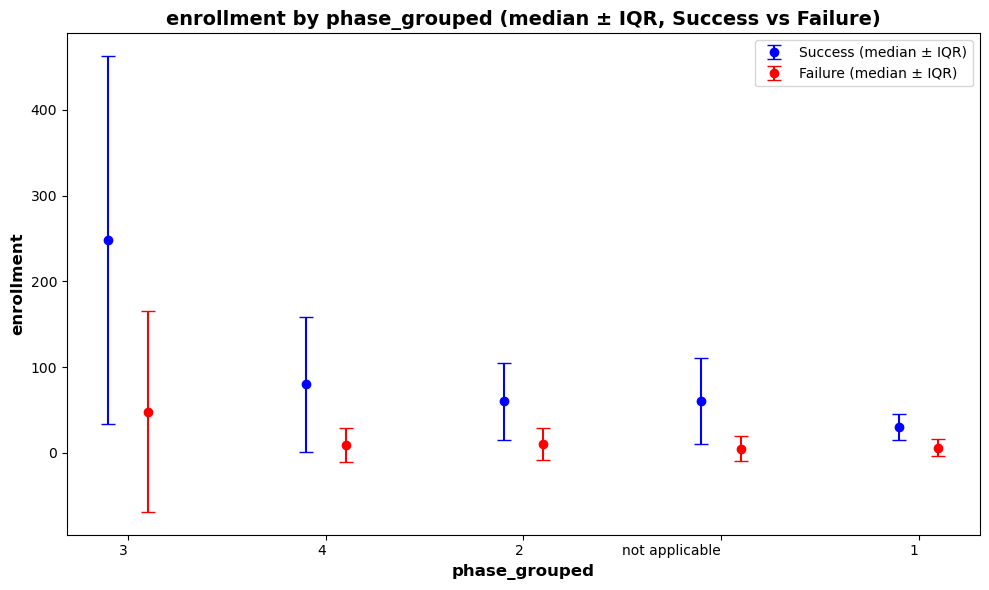

In [11]:
analysis_num_cat_target(df_EDA_3, cat_col = 'phase_grouped', num_col = 'enrollment', show = True)

,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,factorial,3468,362,120.0,310.0,12.0,69.25,1.01e+06,2.6e-81,0.309
1,parallel,133610,20706,88.0,163.0,13.0,57.00,2.21e+09,0,0.354
2,None,4972,819,60.0,119.0,8.0,35.00,3.33e+06,1.1e-188,0.385
3,unknown,2993,274,47.0,78.0,28.0,56.25,5.52e+05,1.7e-21,0.166
4,sequential,4460,1349,42.0,60.0,11.0,31.00,4.69e+06,8.4e-214,0.409
5,single_group,52432,12596,31.0,50.0,5.0,18.00,5.41e+08,0,0.436
6,crossover,23112,1983,30.0,33.0,5.0,18.00,3.82e+07,0,0.311


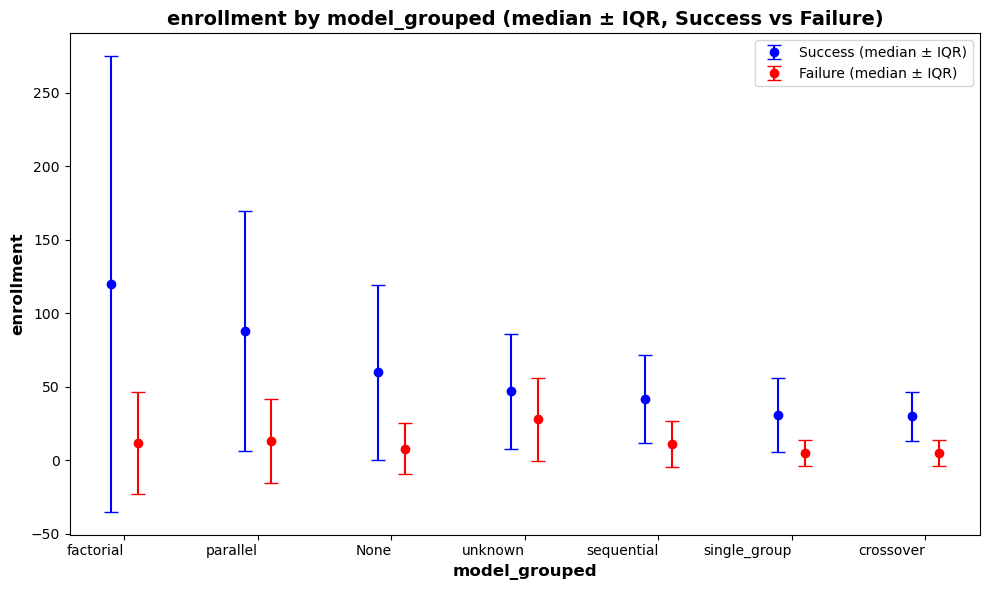

In [12]:
analysis_num_cat_target(df_EDA_3, cat_col = 'model_grouped', num_col = 'enrollment', show = True)

,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,randomized,149502,21155,77.0,154.0,12.0,55.0,2.49e+09,0,0.330
1,None,4972,819,60.0,119.0,8.0,35.0,3.33e+06,1.1e-188,0.385
2,unknown,3329,450,40.0,38.0,12.0,33.0,1.12e+06,2.5e-64,0.275
3,non_randomized,67244,15665,35.0,57.0,6.0,20.0,8.55e+08,0,0.423


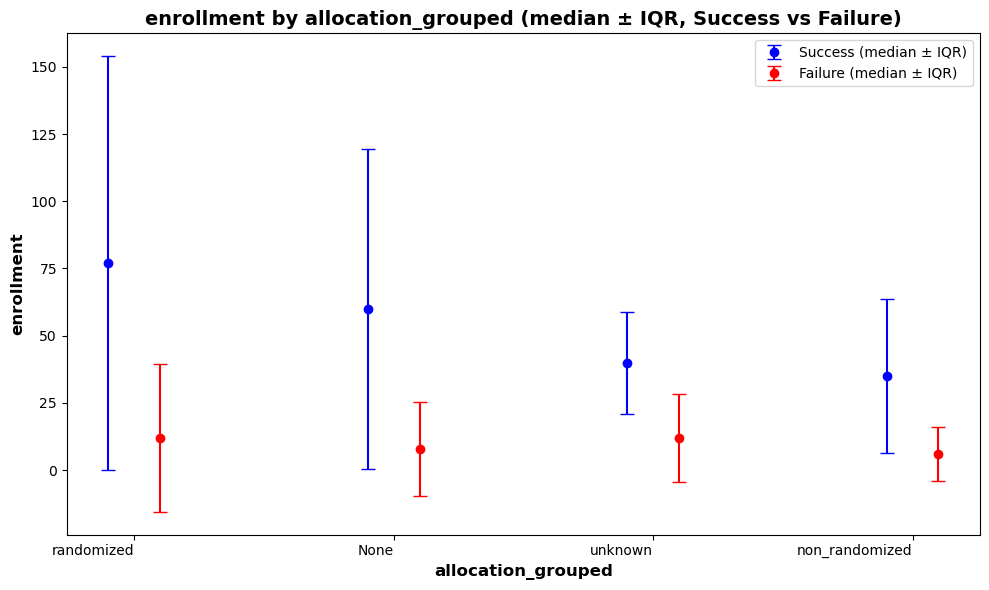

In [13]:
analysis_num_cat_target(df_EDA_3, cat_col = 'allocation_grouped', num_col = 'enrollment', show = True)

,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,cancers,27449,9274,1461.0,1359.00,971.0,956.50,1.67e+08,0,0.238
1,genetic_disorders,160,37,867.0,940.50,863.0,832.00,3.07e+03,0.73,0.025
2,mental_disorders,10699,1454,790.0,938.50,641.0,789.75,8.85e+06,1.2e-17,0.078
3,cardiovascular_diseases,11500,2090,761.0,981.00,759.5,891.00,1.22e+07,0.39,0.007
4,Multiple,38905,6721,700.0,927.00,733.0,883.00,1.27e+08,0.00066,0.016
5,neurological_disorders,10418,1819,700.0,871.75,730.0,821.00,9.36e+06,0.41,0.007
6,gastrointestinal_disorders,6462,1300,679.5,792.00,725.5,778.25,4.09e+06,0.15,0.016
7,musculoskeletal_disorders,6960,1029,674.0,848.75,731.0,885.00,3.40e+06,0.0078,0.030
8,reproductive_health,2918,430,633.5,761.00,709.5,772.00,5.82e+05,0.016,0.042
9,renal/urological_disorders,2904,511,622.5,802.25,701.0,820.50,6.97e+05,0.03,0.037


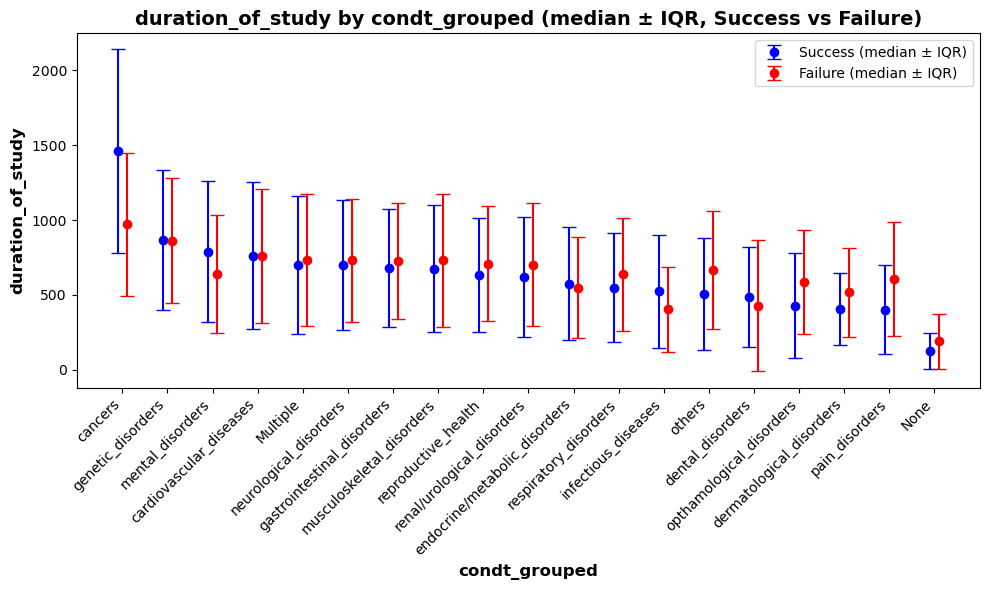

In [14]:
analysis_num_cat_target(df_EDA_3, cat_col = 'condt_grouped', num_col = 'duration_of_study', rotation = 45, show = True)

,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,unknown,2993,274,1461.0,1550.00,863.0,1073.25,5.37e+05,1.9e-17,0.149
1,single_group,52432,12596,792.0,1120.00,767.0,918.00,3.34e+08,0.03,0.008
2,factorial,3468,362,791.0,1096.00,670.0,915.25,6.88e+05,0.0026,0.049
3,parallel,133610,20706,651.0,877.00,730.0,852.00,1.33e+09,4.1e-22,0.025
4,None,4972,819,641.0,913.25,681.0,823.00,2.03e+06,0.81,0.003
5,sequential,4460,1349,545.0,837.25,737.0,803.00,2.61e+06,1.2e-13,0.097
6,crossover,23112,1983,273.0,579.00,516.0,801.00,1.70e+07,3.5e-81,0.120


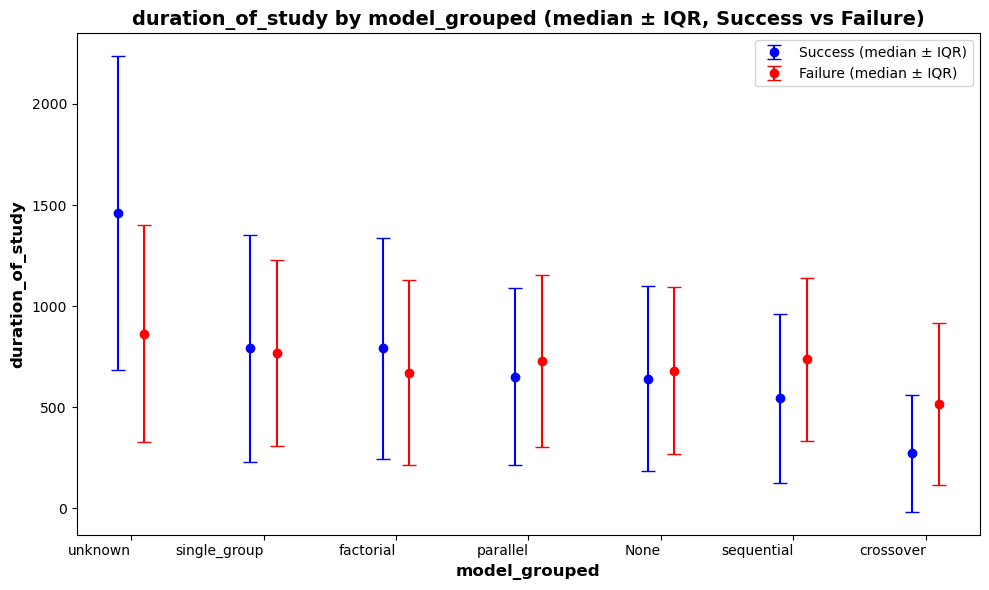

In [15]:
analysis_num_cat_target(df_EDA_3, cat_col = 'model_grouped', num_col = 'duration_of_study', show = True)

,Category,Total_success,Total_failure,Median_success,IQR_success,Median_failure,IQR_failure,U_stat,p_value,Effect_size_r
0,behavioral,26382,1798,90.0,191.00,5.0,30.75,4.08e+07,0,0.305
1,diagnostic_test,1854,262,80.0,155.25,4.0,36.75,4.06e+05,1.3e-69,0.383
2,biological,8743,1446,75.0,272.00,5.0,22.00,1.08e+07,0,0.429
3,Multiple,27721,6743,60.0,111.00,7.0,30.00,1.54e+08,0,0.447
4,drug,85018,17924,60.0,122.00,11.0,41.00,1.19e+09,0,0.367
5,procedure,13666,1957,60.0,92.00,6.0,40.00,2.16e+07,0,0.351
6,other,29982,2636,57.0,90.00,7.0,36.00,6.37e+07,0,0.289
7,device,22477,4299,50.0,80.00,6.0,30.00,7.74e+07,0,0.382
8,genetic,271,69,48.0,136.00,5.0,12.00,1.55e+04,4.5e-17,0.455
9,combination_product,583,107,48.0,75.00,3.0,13.00,5.40e+04,2.2e-33,0.458


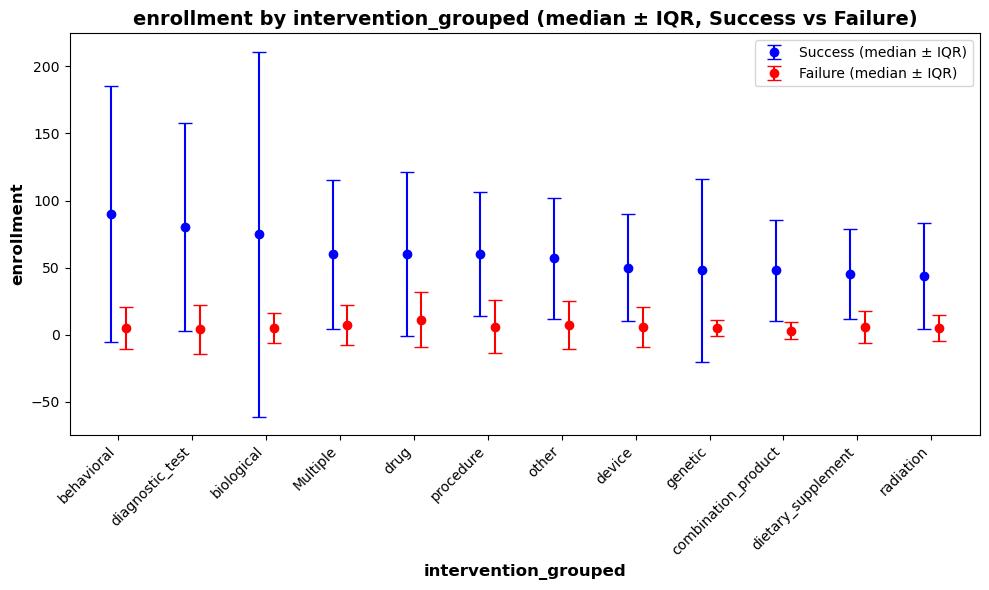

In [16]:
analysis_num_cat_target(df_EDA_3, cat_col = 'intervention_grouped', num_col = 'enrollment', rotation = 45, show = True)

In [17]:
# Export dataset for EDA Part 3
df_EDA_3.to_csv(DATA_PROCESSED / "df_EDA_3.csv", index=False)
print("✅ Saved dataset: df_EDA_3.csv")

✅ Saved dataset: df_EDA_3.csv


## Summary of Findings – EDA_3

1. **Categorical × Categorical Analysis**
   - Ran Chi² tests across 44 pairs of categorical features.
   - 11 pairs showed **Cramér’s V > 0.15** (non-trivial association).
   - Showed inline plots for 5 key pairs:
     - Phase × Condition
     - Intervention × Condition
     - Phase × Intervention
     - Intervention × Model
     - Condition × Purpose
   - Remaining >0.15 pairs were saved to results folder.

2. **Key Observations**
   - Phase × Condition: cancer trials in Phase 2 showed higher failures.
   - Intervention × Model: drug trials with single-group design had higher failure rates.
   - Condition × Purpose: oncology trials were more treatment-focused, with higher risk.
   - Parallel design remains the most stable across conditions and interventions.

3. **Categorical × Numerical Analysis**
   - Enrollment and duration distributions vary significantly by phase, model, allocation, and condition.
   - Mann–Whitney U tests confirmed these differences, though effect sizes were generally small-to-moderate.


### ✅ Outputs
- Strong categorical pair results → `../results/EDA3_outputs/Multivariate_cat_summary.csv`
- Heatmaps and plots → `../results/EDA3_outputs/`
- Mann–Whitney U summaries → saved per feature in results folder


**Next Step → Modeling**
Move from exploratory analysis into feature engineering and predictive modeling 
(Logistic Regression, XGBoost, etc.).


---

### Summary of EDA 3 (Multivariate Analysis)

This phase explored **inter-feature dependencies** to identify how combinations of clinical trial factors jointly influence outcomes (Success vs Failure).


#### Categorical × Categorical Associations (Chi² + Cramér’s V)

Top interacting feature pairs (Cramér’s V > 0.15):

- **Intervention × Condition (0.19):**  
  Drug and Device interventions dominate across most therapeutic areas, while Behavioral trials are concentrated in mental-health-related categories.

- **Phase × Condition (0.175):**  
  Phase 2–3 trials are overrepresented in Cancer, Cardiovascular, and Metabolic disorders, reflecting condition-specific trial maturity.

- **Intervention × Model (0.17):**  
  Drug trials rely heavily on Parallel designs; Behavioral and Procedure-based studies often use Single-group or Sequential models.

- **Condition × Model (0.164):**  
  Complex models (Parallel/Crossover) appear more frequently in high-enrollment conditions such as Oncology and Neurology.

- **Condition × Purpose (0.16):**  
  Treatment dominates across conditions, while Prevention and Supportive-Care are more common in chronic diseases.

These findings show that **trial architecture and disease focus are highly interlinked**, explaining structural dependencies across features.

---

#### Categorical × Numerical Relationships (Mann–Whitney U tests)

Enrollment and duration distributions were compared between categorical groups (Success vs Failure):

- **Phase:** Median enrollment increases steadily from Phase 1 → 3 (effect ≈ 0.41); successful trials consistently recruit more participants.  
- **Model:** Parallel and crossover designs display higher median enrollments and variability (effect ≈ 0.35–0.40).  
- **Allocation:** Randomized trials show greater participant spread and higher success rates than non-randomized ones (effect ≈ 0.33–0.40).  
- **Condition:** Cancer studies are linked with higher participant counts, reinforcing Phase–Condition dependencies.

---

#### Key Takeaways

- **Enrollment** is the most influential numeric factor driving success across all trial configurations.  
- **Design elements** (Phase, Model, Allocation) combine to shape trial outcomes more than any individual variable.  
- **Condition × Intervention** effects confirm that trial behavior differs significantly by disease domain.  
- The dataset now reflects **interaction-aware dependencies**, critical for informed feature selection during modeling.

---

### Overall Interpretation

Multivariate exploration confirms that **clinical trial success depends on feature combinations rather than single factors**.  
High-enrollment, randomized, Parallel or Crossover trials — especially in later phases and involving Drug interventions — show the strongest likelihood of completion.  
These results establish the **final analytical foundation** for modeling and predictive experimentation.

---

📁 **Next Notebook:** `9_df_final.ipynb` — **final modeling-ready datasets** 
